## Preparation

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=ff99da967c72e034201f8cc236cc6bda4d44da7612bb774c9ffdf254e34c6b9f
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("PySpark Example").getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Furniture.csv to Furniture.csv


In [ ]:
df = spark.read.csv("Furniture.csv", header=True, inferSchema=True)


## Import Data

In [45]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Furniture Sales Analysis").getOrCreate()

df = spark.read.csv("Furniture.csv", header=True, inferSchema=True)

df.show(5)

df.printSchema()


+------------------+-----------------+-----+------------------+---------+-------------------+-------------+--------+--------+-----+--------+------+----------+------+------------------+
|             price|             cost|sales|     profit_margin|inventory|discount_percentage|delivery_days|category|material|color|location|season|store_type| brand|           revenue|
+------------------+-----------------+-----+------------------+---------+-------------------+-------------+--------+--------+-----+--------+------+----------+------+------------------+
| 218.5430534813131|181.6109315609271|   40| 16.89924311574788|      105|  27.79643342252926|            9|     Bed| Plastic|  Red|   Rural|Spring|    Online|BrandA|3949.1652384225717|
| 477.8214378844623|385.0338270000528|    7|19.418888213811293|      192| 26.943715041386362|            6|   Chair|   Glass| Blue|   Rural|Summer|    Online|BrandD|-3521.002257553382|
| 379.3972738151323|276.7367651620845|   32| 27.05884194177706|       59|  

## EDA

### Memeriksa Missing Values

In [46]:
from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-----+----+-----+-------------+---------+-------------------+-------------+--------+--------+-----+--------+------+----------+-----+-------+
|price|cost|sales|profit_margin|inventory|discount_percentage|delivery_days|category|material|color|location|season|store_type|brand|revenue|
+-----+----+-----+-------------+---------+-------------------+-------------+--------+--------+-----+--------+------+----------+-----+-------+
|    0|   0|    0|            0|        0|                  0|            0|       0|       0|    0|       0|     0|         0|    0|      0|
+-----+----+-----+-------------+---------+-------------------+-------------+--------+--------+-----+--------+------+----------+-----+-------+



### Deskripsi Statistik

In [47]:
df.describe(['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue']).show()


+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+------------------+
|summary|             price|              cost|            sales|     profit_margin|         inventory| discount_percentage|    delivery_days|           revenue|
+-------+------------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+------------------+
|  count|              2500|              2500|             2500|              2500|              2500|                2500|             2500|              2500|
|   mean|274.49521946929156| 191.9301066813916|           24.924| 30.20857134025875|           97.7156|  14.947616045606294|            4.894| 5926.853657097815|
| stddev|  130.898452238649| 98.59075124611671|14.05006710853374|11.536803694582236|57.616228343648366|   8.621546737995276|2.559020014258066| 6902.737603740921|
|    min| 50.70429733616281|

## Transformasi Data

### Feature Engineering

In [48]:
df_cleaned = df.na.drop(subset=['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue'])


In [49]:
from pyspark.sql.functions import expr

df_transformed = df_cleaned.withColumn("Discount_Impact", expr("profit_margin / sales")) # Melihat bagaimana impact diskon terhadap profit
df_transformed.select("sales", "profit_margin", "Discount_Impact").show(5)


+-----+------------------+-------------------+
|sales|     profit_margin|    Discount_Impact|
+-----+------------------+-------------------+
|   40| 16.89924311574788|  0.422481077893697|
|    7|19.418888213811293| 2.7741268876873275|
|   32| 27.05884194177706| 0.8455888106805332|
|   48|11.758114255522672|0.24496071365672234|
|   19|41.981019378863884| 2.2095273357296783|
+-----+------------------+-------------------+
only showing top 5 rows



### Normalisasi Data

In [50]:
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler = VectorAssembler(inputCols=['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue'], outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
df_scaled = scaler.fit(assembler.transform(df_transformed)).transform(assembler.transform(df_transformed))
df_scaled.select("scaled_features").show(5)


+--------------------+
|     scaled_features|
+--------------------+
|[-0.4274471166852...|
|[1.55331262469380...|
|[0.80140026525744...|
|[0.34302237842747...|
|[-1.1786757492663...|
+--------------------+
only showing top 5 rows



## Visualisasi

### Heatmap Korelasi

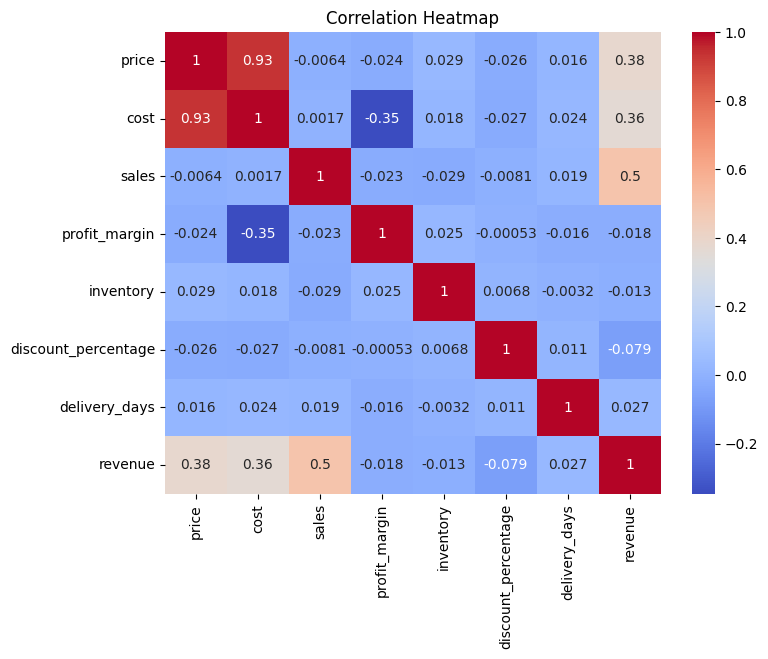

In [51]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue'], outputCol=vector_col)
df_vector = assembler.transform(df_scaled).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).head()[0]

plt.figure(figsize=(8,6))
sns.heatmap(matrix.toArray(), annot=True, cmap="coolwarm", xticklabels=['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue'],
            yticklabels=['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue'])
plt.title("Correlation Heatmap")
plt.show()


### Count Plot for Categorical Columns

In [52]:
categorical_columns = ['category', 'material', 'color', 'location', 'season', 'store_type', 'brand']

print("Kolom kategori:", categorical_columns)


Kolom kategori: ['category', 'material', 'color', 'location', 'season', 'store_type', 'brand']


<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


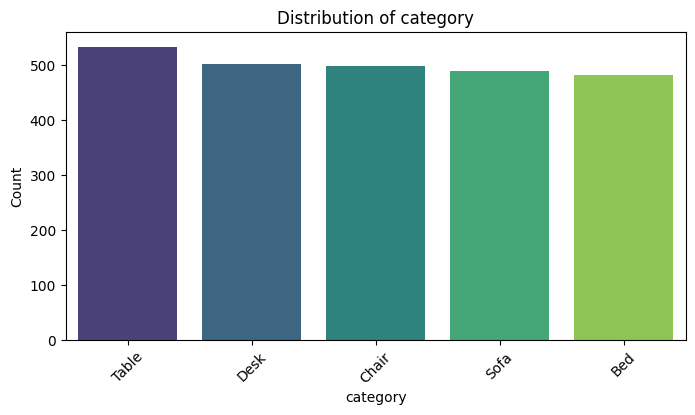

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


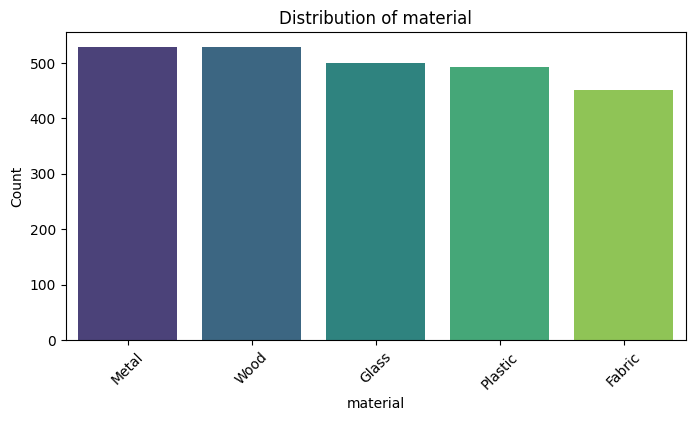

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


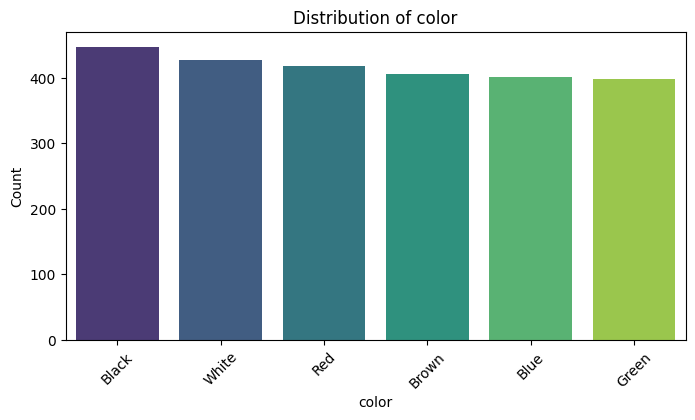

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


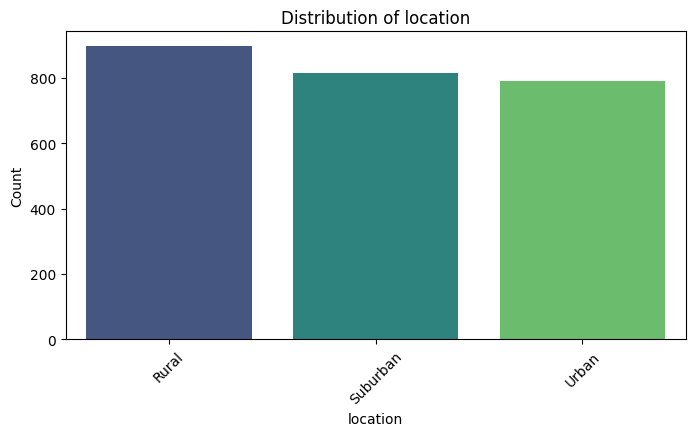

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


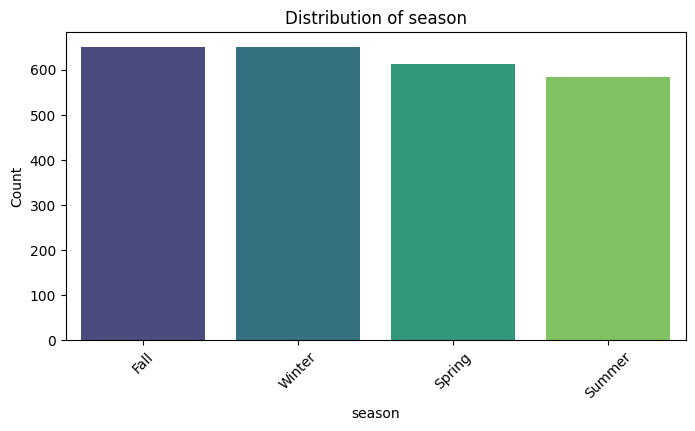

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


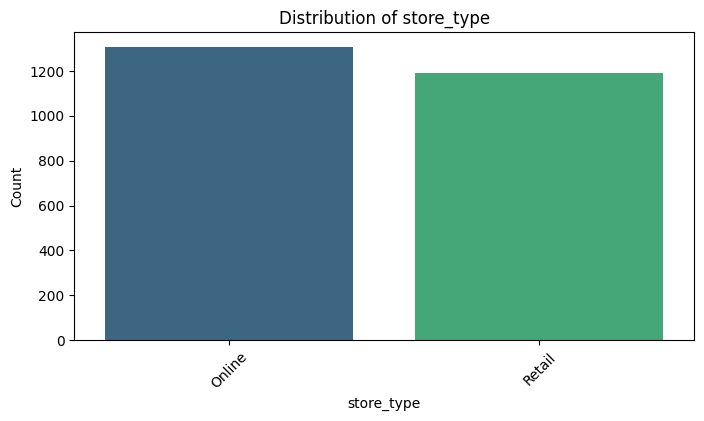

<ipython-input-53-29e9b7e0dcf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')


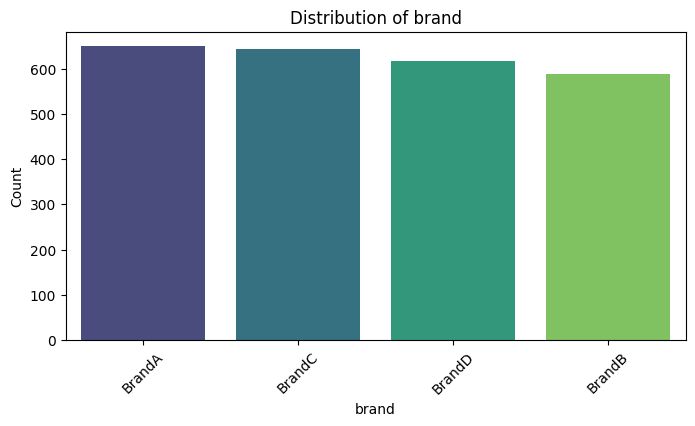

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_distribution(df, column_name):
    category_count = df.groupBy(column_name).count().orderBy('count', ascending=False)

    category_count_pd = category_count.toPandas()

    plt.figure(figsize=(8,4))
    sns.barplot(x=column_name, y='count', data=category_count_pd, palette='viridis')
    plt.title(f'Distribution of {column_name}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

for col in categorical_columns:
    plot_categorical_distribution(df, col)


### Distribution of Numerical columns

In [54]:
numeric_columns = ['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue']

print("Kolom numerik:", numeric_columns)


Kolom numerik: ['price', 'cost', 'sales', 'profit_margin', 'inventory', 'discount_percentage', 'delivery_days', 'revenue']


#### Histogram

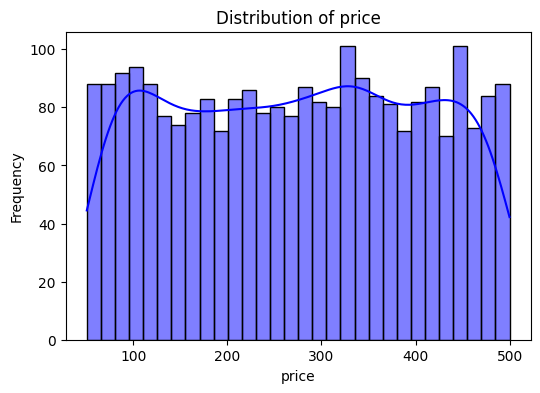

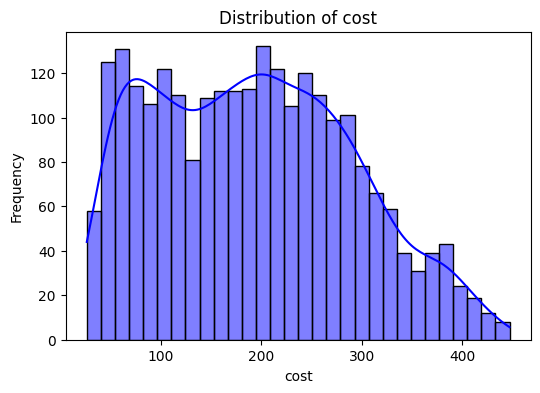

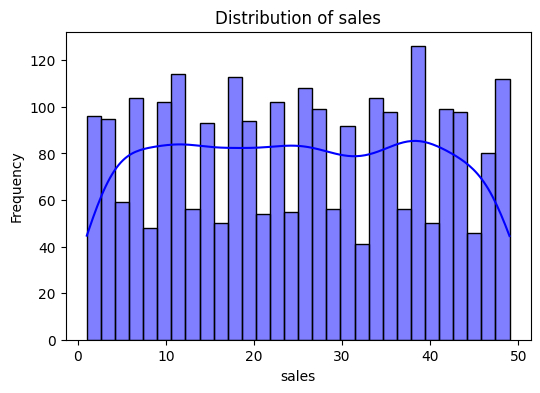

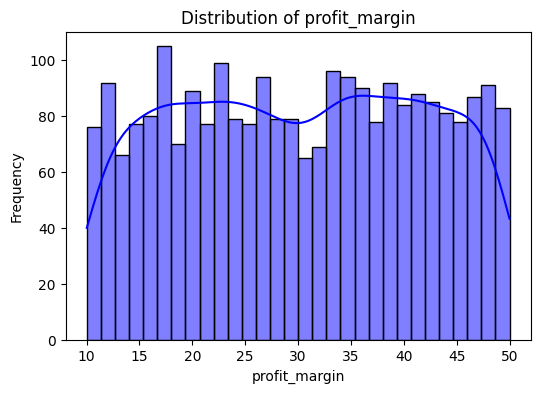

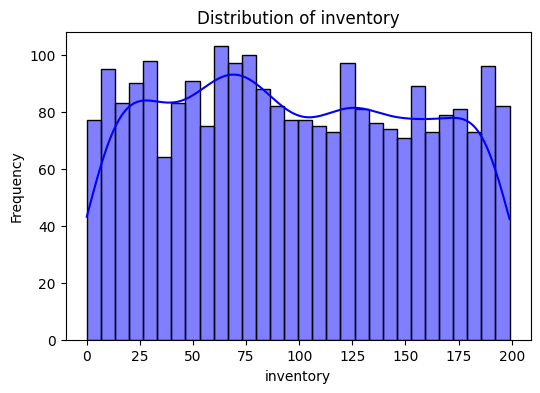

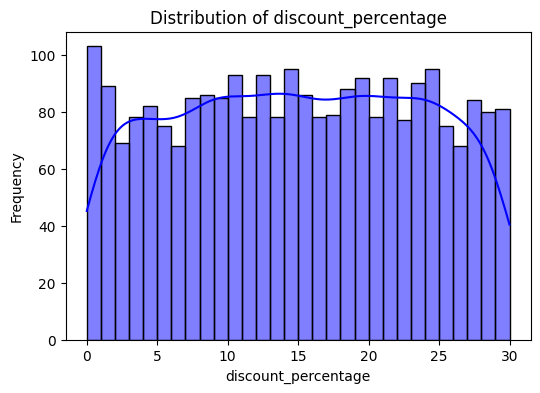

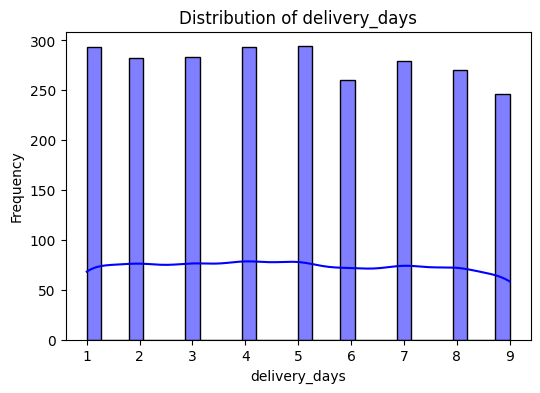

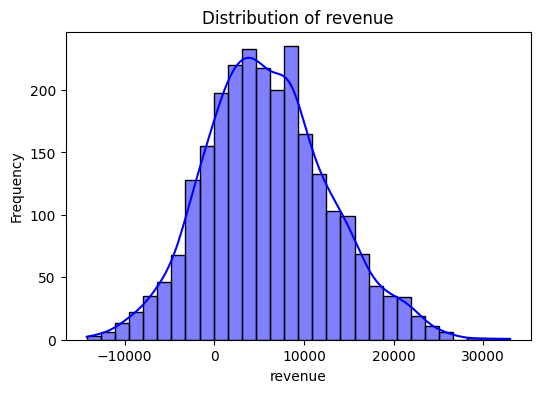

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column_name):
    column_data_pd = df.select(column_name).toPandas()

    plt.figure(figsize=(6,4))
    sns.histplot(column_data_pd[column_name], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

for col in numeric_columns:
    plot_numeric_distribution(df, col)


#### Boxplot

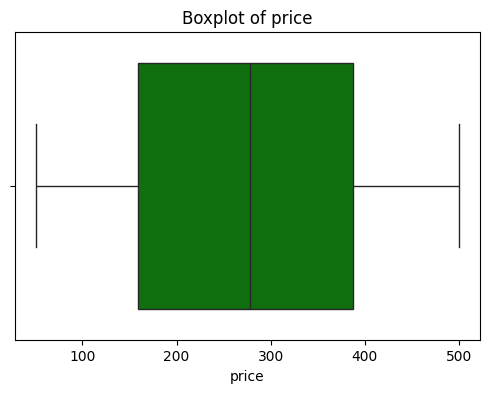

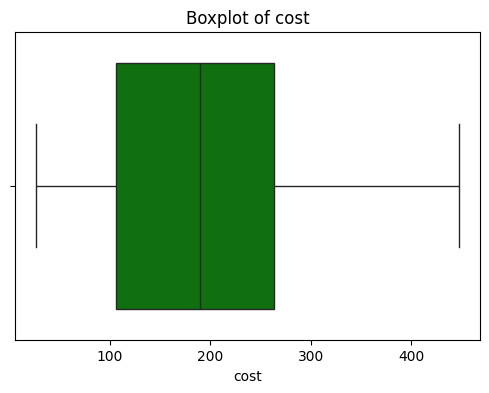

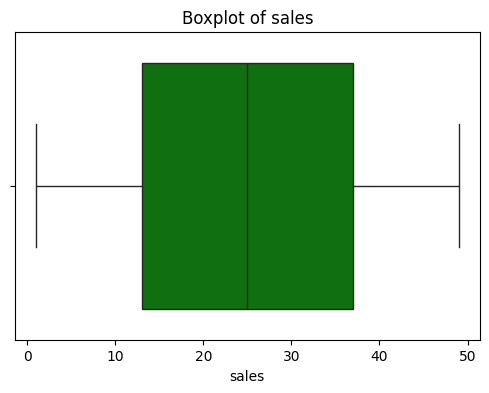

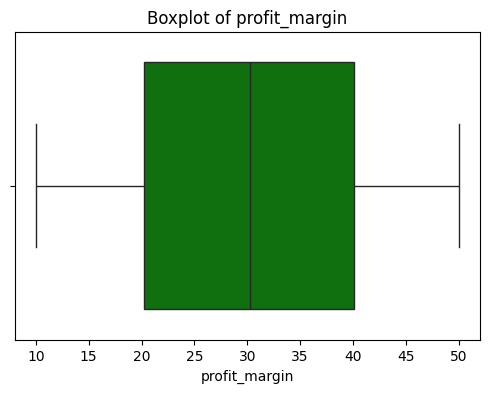

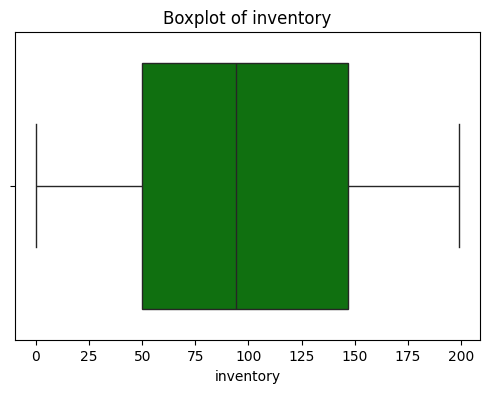

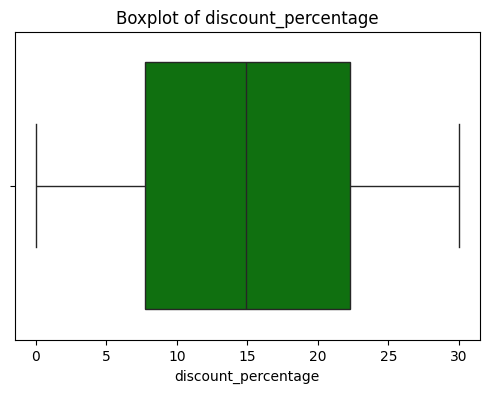

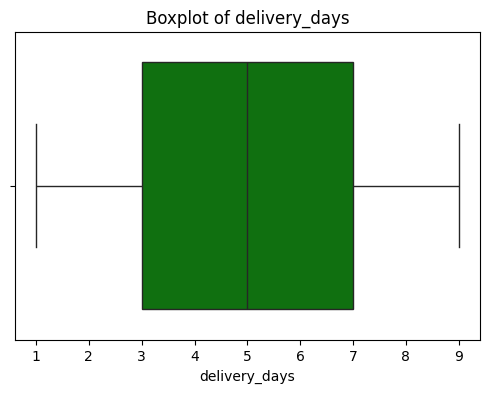

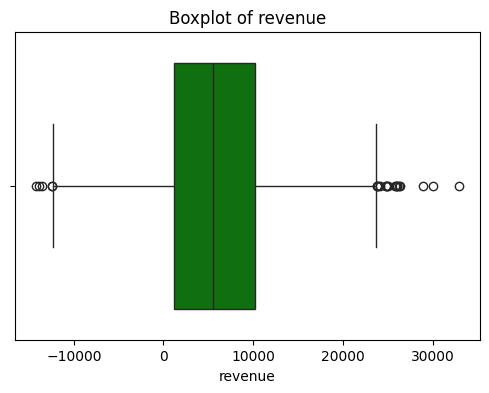

In [56]:
def plot_numeric_boxplot(df, column_name):
    column_data_pd = df.select(column_name).toPandas()

    plt.figure(figsize=(6,4))
    sns.boxplot(x=column_data_pd[column_name], color='green')
    plt.title(f'Boxplot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

for col in numeric_columns:
    plot_numeric_boxplot(df, col)
